In [17]:
import matplotlib.pyplot as plt
import xarray as xr

from ocr.config import OCRConfig
from ocr.risks.fire import calculate_wind_adjusted_risk

In [3]:
config = OCRConfig(storage_root='/tmp/era5-vs-conus404')
config

[14:05:50] Initialized/Opened icechunk repository                          ]8;id=639093;file:///Users/andersy005/devel/carbonplan/ocr/ocr/config.py\config.py]8;;\:]8;id=998441;file:///Users/andersy005/devel/carbonplan/ocr/ocr/config.py#900\900]8;;\
           Opened icechunk repository at                                   ]8;id=60212;file:///Users/andersy005/devel/carbonplan/ocr/ocr/config.py\config.py]8;;\:]8;id=580871;file:///Users/andersy005/devel/carbonplan/ocr/ocr/config.py#915\915]8;;\
           /tmp/era5-vs-conus404/intermediate/fire-risk/tensor/QA/template              
           .icechunk with branch main in writable mode.                                 
           No template found in icechunk store. Creating a new template    ]8;id=355655;file:///Users/andersy005/devel/carbonplan/ocr/ocr/config.py\config.py]8;;\:]8;id=592115;file:///Users/andersy005/devel/carbonplan/ocr/ocr/config.py#903\903]8;;\
           dataset.                                 

OCRConfig(branch=<Branch.QA: 'QA'>, storage_root='/tmp/era5-vs-conus404', vector=VectorConfig(branch=<Branch.QA: 'QA'>, storage_root='/tmp/era5-vs-conus404', prefix='intermediate/fire-risk/vector/QA', output_prefix='output/fire-risk/vector/QA'), icechunk=IcechunkConfig(branch=<Branch.QA: 'QA'>, storage_root='/tmp/era5-vs-conus404', prefix='intermediate/fire-risk/tensor/QA/template.icechunk'), chunking=<POLYGON ((-64.054 22.428, -64.054 52.482, -128.387 52.482, -128.387 22.428,...>, coiled=CoiledConfig(tag={'Project': 'OCR'}, forward_aws_credentials=True, region='us-west-2', ntasks=1, vm_type='m8g.large'))

In [4]:
region_id = 'y2_x4'
y_slice, x_slice = config.chunking.region_id_to_latlon_slices(region_id=region_id)
y_slice, x_slice

(slice(np.float64(48.785922350422005), np.float64(46.93795907980169), None),
 slice(np.float64(-122.84366640817825), np.float64(-121.45769395521302), None))

In [12]:
%%time
ds = calculate_wind_adjusted_risk(x_slice=x_slice, y_slice=y_slice).load()

[14:17:51] Calculating wind risk for region with x_slice:                    ]8;id=472506;file:///Users/andersy005/devel/carbonplan/ocr/ocr/risks/fire.py\fire.py]8;;\:]8;id=178951;file:///Users/andersy005/devel/carbonplan/ocr/ocr/risks/fire.py#370\370]8;;\
           slice(np.float64(-122.84366640817825),                                       
           np.float64(-121.45769395521302), None) and y_slice:                          
           slice(np.float64(48.785922350422005),                                        
           np.float64(46.93795907980169), None)                                         


/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


CPU times: user 43.6 s, sys: 13.5 s, total: 57.1 s
Wall time: 2min 25s


In [13]:
ds

<xarray.Dataset> Size: 432MB
Dimensions:         (latitude: 6000, longitude: 4500)
Coordinates:
  * latitude        (latitude) float64 48kB 48.79 48.79 48.79 ... 46.94 46.94
  * longitude       (longitude) float64 36kB -122.8 -122.8 ... -121.5 -121.5
Data variables:
    risk_2011       (latitude, longitude) float32 108MB 0.0 0.0 ... 0.9729
    risk_2047       (latitude, longitude) float32 108MB 0.0 0.0 ... 2.335 2.331
    wind_risk_2011  (latitude, longitude) float32 108MB -0.0 -0.0 ... 0.7895
    wind_risk_2047  (latitude, longitude) float32 108MB -0.0 -0.0 ... 2.087

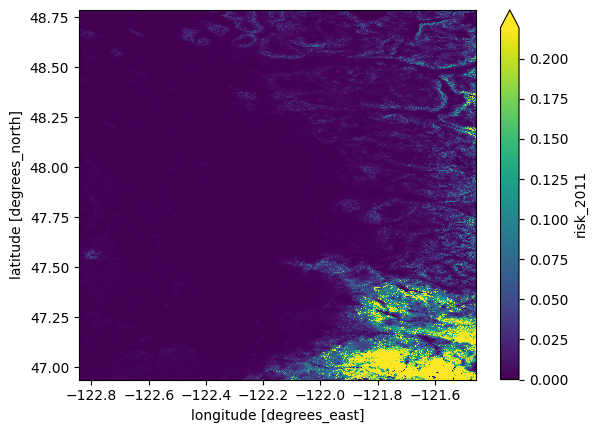

In [8]:
ds.risk_2011.plot(robust=True)
ds.risk_2011.plot(robust=True)
ds.risk_2011.plot(robust=True)
ds.risk_2011.plot(robust=True);

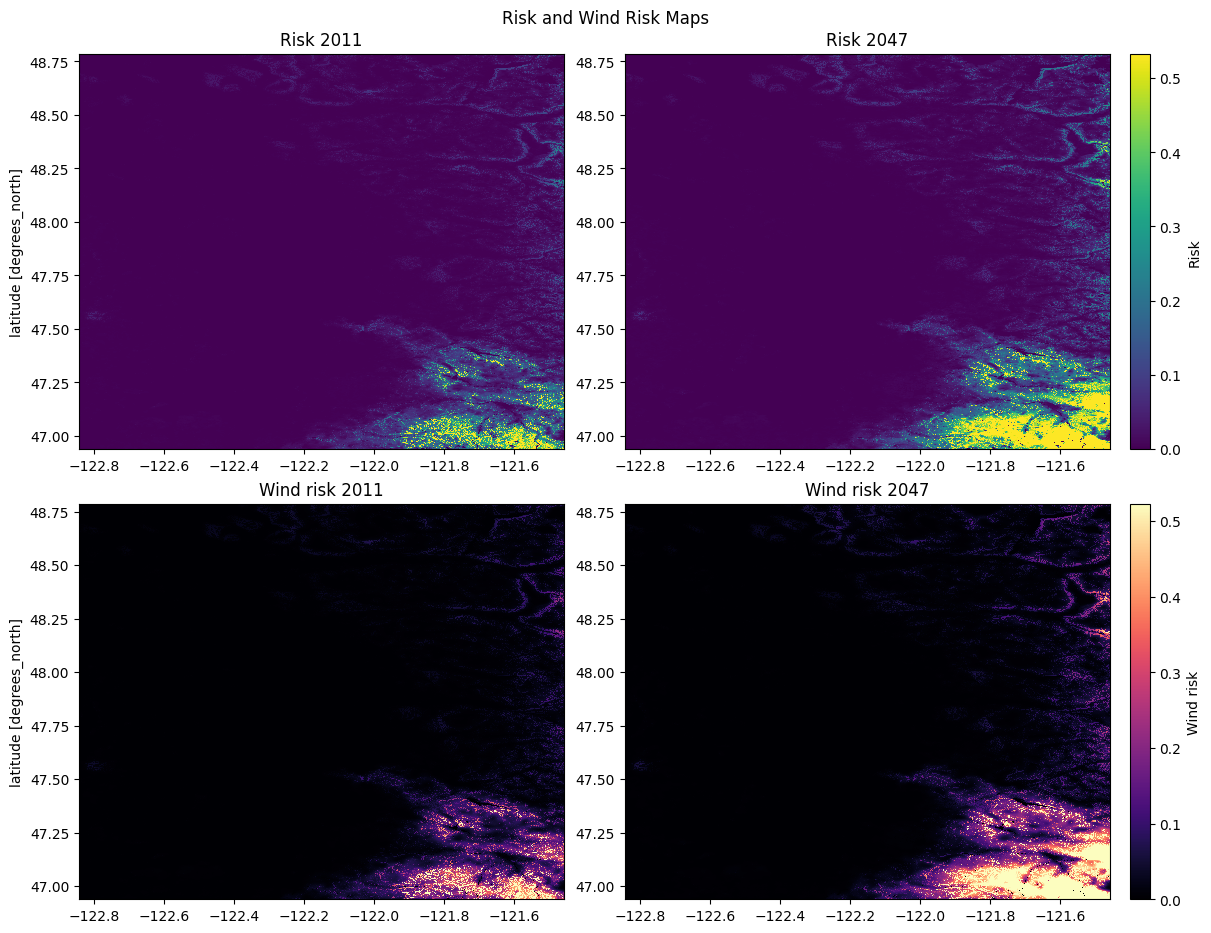

In [14]:
# Shortcuts
r11 = ds.risk_2011
r47 = ds.risk_2047
w11 = ds.wind_risk_2011
w47 = ds.wind_risk_2047


def robust_range(arrs, lo=0.02, hi=0.98):
    # Compute group-wise robust limits (2nd–98th percentiles) across multiple DataArrays
    qs = [a.quantile([lo, hi]) for a in arrs]  # dask-friendly; computed when .item() is called
    lo_vals = [q.sel(quantile=lo).item() for q in qs]
    hi_vals = [q.sel(quantile=hi).item() for q in qs]
    return min(lo_vals), max(hi_vals)


# Compute robust limits separately for risk and wind_risk
rvmin, rvmax = robust_range([r11, r47])
wvmin, wvmax = robust_range([w11, w47])

fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

m0 = r11.plot(
    ax=axes[0, 0], add_colorbar=False, vmin=rvmin, vmax=rvmax, cmap='viridis', rasterized=True
)
axes[0, 0].set_title('Risk 2011')

m1 = r47.plot(
    ax=axes[0, 1], add_colorbar=False, vmin=rvmin, vmax=rvmax, cmap='viridis', rasterized=True
)
axes[0, 1].set_title('Risk 2047')

m2 = w11.plot(
    ax=axes[1, 0], add_colorbar=False, vmin=wvmin, vmax=wvmax, cmap='magma', rasterized=True
)
axes[1, 0].set_title('Wind risk 2011')

m3 = w47.plot(
    ax=axes[1, 1], add_colorbar=False, vmin=wvmin, vmax=wvmax, cmap='magma', rasterized=True
)
axes[1, 1].set_title('Wind risk 2047')

# Shared colorbars: top row (risk) and bottom row (wind_risk)
cbar1 = fig.colorbar(m0, ax=[axes[0, 0], axes[0, 1]], fraction=0.035, pad=0.02)
cbar1.set_label('Risk')

cbar2 = fig.colorbar(m2, ax=[axes[1, 0], axes[1, 1]], fraction=0.035, pad=0.02)
cbar2.set_label('Wind risk')

# Optional cosmetics
for ax in axes.ravel():
    ax.set_xlabel('')  # reduce label clutter; keep y labels on left column
axes[0, 1].set_ylabel('')
axes[1, 1].set_ylabel('')

fig.suptitle('Risk and Wind Risk Maps', y=1.02)
plt.show()

In [28]:
%%time


def calculate_wind_adjusted_risk_conus404(*, x_slice: slice, y_slice: slice) -> xr.Dataset:
    from ocr import catalog
    from ocr.risks.fire import classify_wind

    # Open input dataset: USFS 30m community risk, USFS 30m interpolated 2011 climate runs and 1/4 degree? ERA5 Wind.
    climate_run_2011 = catalog.get_dataset('2011-climate-run-30m-4326').to_xarray()[['BP']]
    climate_run_2047 = catalog.get_dataset('2047-climate-run-30m-4326').to_xarray()[['BP']]

    rps_30 = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()[
        ['BP', 'CRPS', 'RPS']
    ]

    rps_30_subset = rps_30.sel(latitude=y_slice, longitude=x_slice)
    climate_run_2011_subset = climate_run_2011.sel(latitude=y_slice, longitude=x_slice).chunk(
        {'latitude': 6000, 'longitude': 4500}
    )
    climate_run_2047_subset = climate_run_2047.sel(latitude=y_slice, longitude=x_slice).chunk(
        {'latitude': 6000, 'longitude': 4500}
    )

    path = 's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35-reprojected.zarr'
    direction_modes_sfc = (
        xr.open_zarr(path).wind_direction_histogram.sel(latitude=y_slice, longitude=x_slice).load()
    )
    wind_informed_bp_float_corrected_2011 = classify_wind(
        climate_run_subset=climate_run_2011_subset,
        direction_modes_sfc=direction_modes_sfc,
        rps_30_subset=rps_30_subset,
    )
    wind_informed_bp_float_corrected_2047 = classify_wind(
        climate_run_subset=climate_run_2047_subset,
        direction_modes_sfc=direction_modes_sfc,
        rps_30_subset=rps_30_subset,
    )

    # Add in non-wind-adjusted 2011 and 2047 BP*CRPS score for QA comparison

    climate_run_2011_subset_float_corrected = climate_run_2011_subset.assign_coords(
        latitude=wind_informed_bp_float_corrected_2011.latitude,
        longitude=wind_informed_bp_float_corrected_2011.longitude,
    )
    climate_run_2047_subset_float_corrected = climate_run_2047_subset.assign_coords(
        latitude=wind_informed_bp_float_corrected_2047.latitude,
        longitude=wind_informed_bp_float_corrected_2047.longitude,
    )

    risk_4326_combined = (
        climate_run_2011_subset_float_corrected['BP'] * rps_30_subset['CRPS']
    ).to_dataset(name='risk_2011')

    risk_4326_combined['risk_2047'] = (
        climate_run_2047_subset_float_corrected['BP'] * rps_30_subset['CRPS']
    )

    # Adjust USFS 30m CRPS with wind informed burn probability
    risk_4326_combined['wind_risk_2011'] = (
        wind_informed_bp_float_corrected_2011 * rps_30_subset['CRPS']
    )
    risk_4326_combined['wind_risk_2047'] = (
        wind_informed_bp_float_corrected_2047 * rps_30_subset['CRPS']
    )

    return risk_4326_combined.drop_vars(['spatial_ref'])


ds_new = calculate_wind_adjusted_risk_conus404(x_slice=x_slice, y_slice=y_slice)
ds_new

/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/xarray/core/duck_array_ops.py:251: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


CPU times: user 37.6 s, sys: 9.16 s, total: 46.7 s
Wall time: 1min 50s


<xarray.Dataset> Size: 432MB
Dimensions:         (latitude: 6000, longitude: 4500)
Coordinates:
  * latitude        (latitude) float64 48kB 48.79 48.79 48.79 ... 46.94 46.94
  * longitude       (longitude) float64 36kB -122.8 -122.8 ... -121.5 -121.5
Data variables:
    risk_2011       (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    risk_2047       (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2011  (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>
    wind_risk_2047  (latitude, longitude) float32 108MB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

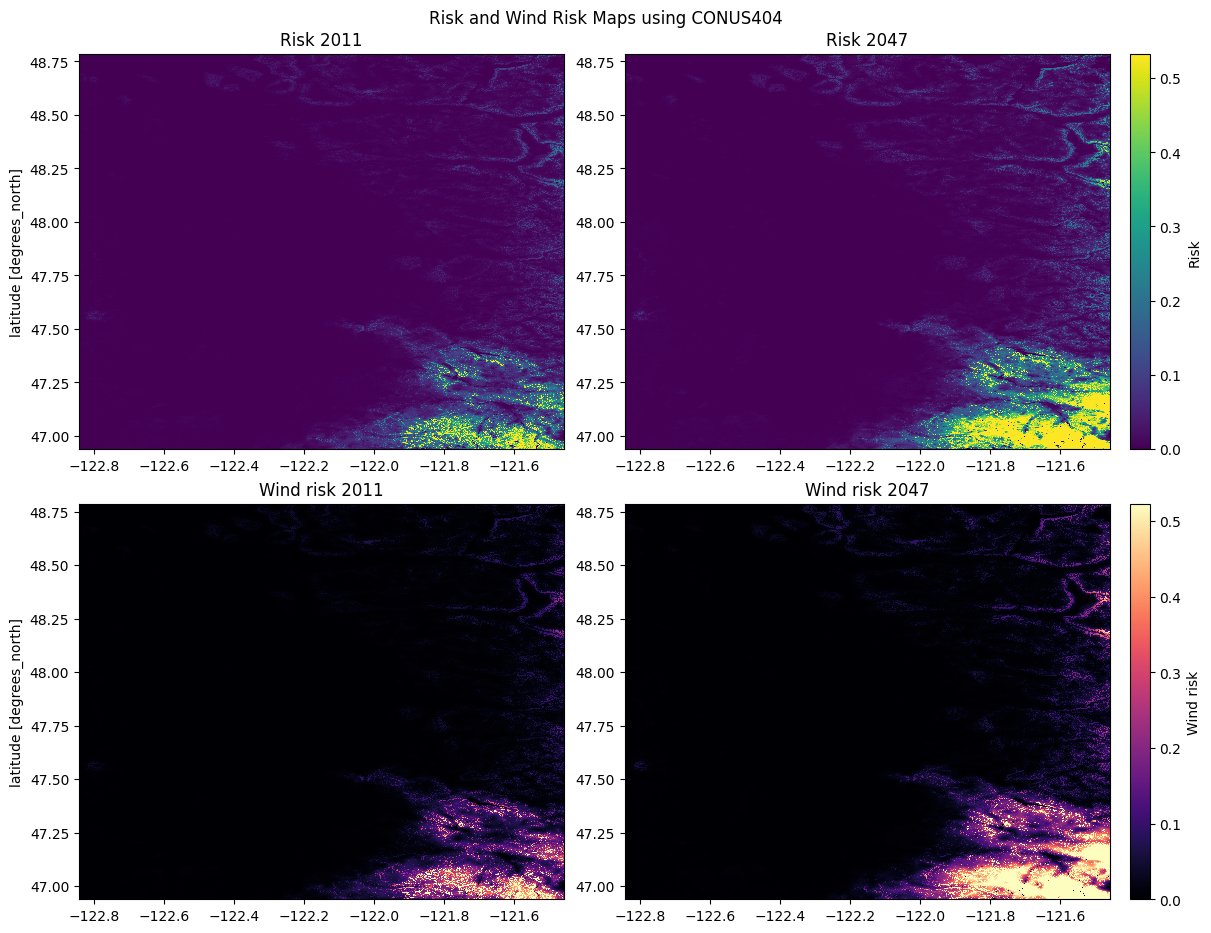

In [31]:
# Shortcuts
ds_new.load()
r11 = ds_new.risk_2011
r47 = ds_new.risk_2047
w11 = ds_new.wind_risk_2011
w47 = ds_new.wind_risk_2047

# Compute robust limits separately for risk and wind_risk
rvmin, rvmax = robust_range([r11, r47])
wvmin, wvmax = robust_range([w11, w47])

fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

m0 = r11.plot(
    ax=axes[0, 0], add_colorbar=False, vmin=rvmin, vmax=rvmax, cmap='viridis', rasterized=True
)
axes[0, 0].set_title('Risk 2011')

m1 = r47.plot(
    ax=axes[0, 1], add_colorbar=False, vmin=rvmin, vmax=rvmax, cmap='viridis', rasterized=True
)
axes[0, 1].set_title('Risk 2047')

m2 = w11.plot(
    ax=axes[1, 0], add_colorbar=False, vmin=wvmin, vmax=wvmax, cmap='magma', rasterized=True
)
axes[1, 0].set_title('Wind risk 2011')

m3 = w47.plot(
    ax=axes[1, 1], add_colorbar=False, vmin=wvmin, vmax=wvmax, cmap='magma', rasterized=True
)
axes[1, 1].set_title('Wind risk 2047')

# Shared colorbars: top row (risk) and bottom row (wind_risk)
cbar1 = fig.colorbar(m0, ax=[axes[0, 0], axes[0, 1]], fraction=0.035, pad=0.02)
cbar1.set_label('Risk')

cbar2 = fig.colorbar(m2, ax=[axes[1, 0], axes[1, 1]], fraction=0.035, pad=0.02)
cbar2.set_label('Wind risk')

# Optional cosmetics
for ax in axes.ravel():
    ax.set_xlabel('')  # reduce label clutter; keep y labels on left column
axes[0, 1].set_ylabel('')
axes[1, 1].set_ylabel('')

fig.suptitle('Risk and Wind Risk Maps using CONUS404', y=1.02)
plt.show()

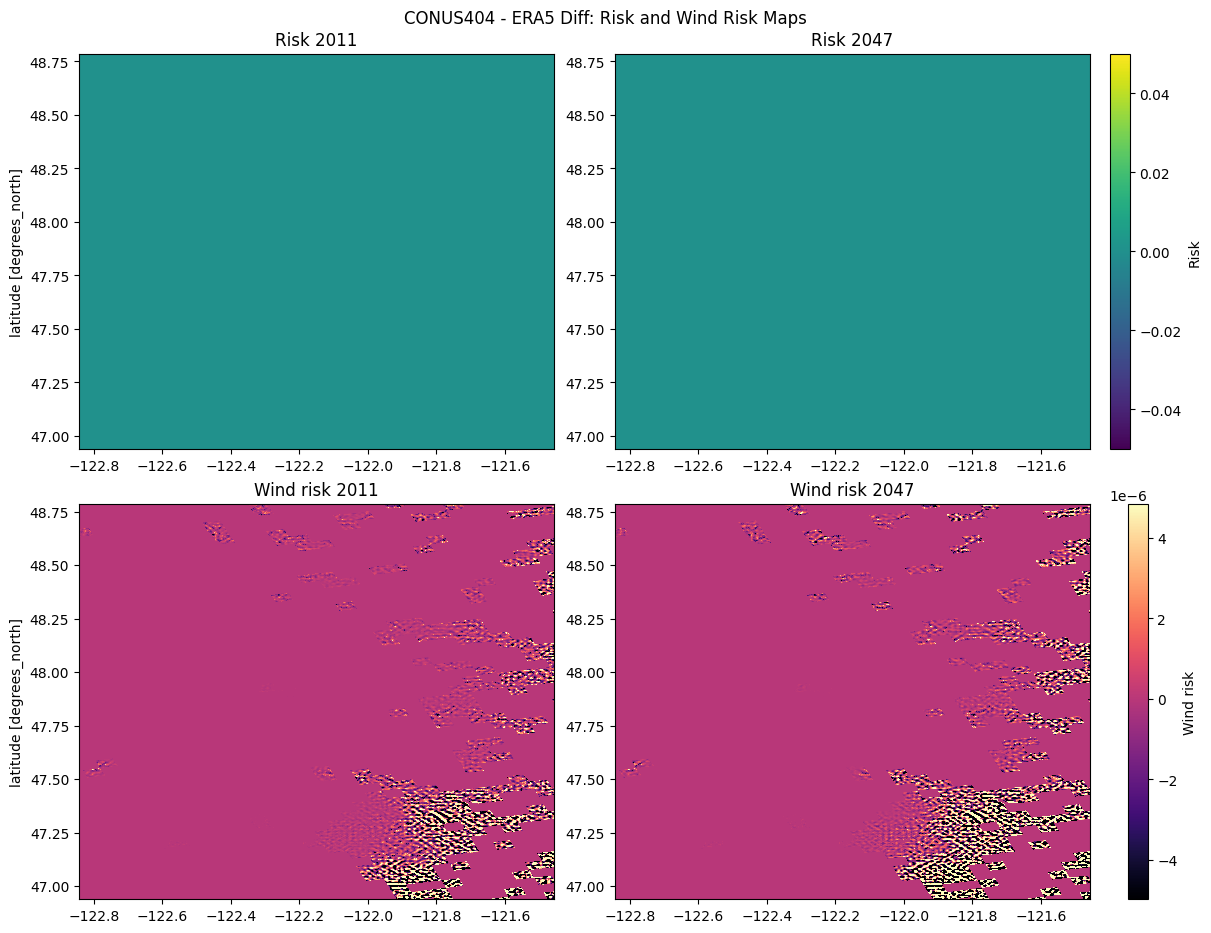

In [33]:
# Shortcuts
diff = (ds_new - ds).load()
r11 = diff.risk_2011
r47 = diff.risk_2047
w11 = diff.wind_risk_2011
w47 = diff.wind_risk_2047

# Compute robust limits separately for risk and wind_risk
rvmin, rvmax = robust_range([r11, r47])
wvmin, wvmax = robust_range([w11, w47])

fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

m0 = r11.plot(
    ax=axes[0, 0], add_colorbar=False, vmin=rvmin, vmax=rvmax, cmap='viridis', rasterized=True
)
axes[0, 0].set_title('Risk 2011')

m1 = r47.plot(
    ax=axes[0, 1], add_colorbar=False, vmin=rvmin, vmax=rvmax, cmap='viridis', rasterized=True
)
axes[0, 1].set_title('Risk 2047')

m2 = w11.plot(
    ax=axes[1, 0], add_colorbar=False, vmin=wvmin, vmax=wvmax, cmap='magma', rasterized=True
)
axes[1, 0].set_title('Wind risk 2011')

m3 = w47.plot(
    ax=axes[1, 1], add_colorbar=False, vmin=wvmin, vmax=wvmax, cmap='magma', rasterized=True
)
axes[1, 1].set_title('Wind risk 2047')

# Shared colorbars: top row (risk) and bottom row (wind_risk)
cbar1 = fig.colorbar(m0, ax=[axes[0, 0], axes[0, 1]], fraction=0.035, pad=0.02)
cbar1.set_label('Risk')

cbar2 = fig.colorbar(m2, ax=[axes[1, 0], axes[1, 1]], fraction=0.035, pad=0.02)
cbar2.set_label('Wind risk')

# Optional cosmetics
for ax in axes.ravel():
    ax.set_xlabel('')  # reduce label clutter; keep y labels on left column
axes[0, 1].set_ylabel('')
axes[1, 1].set_ylabel('')

fig.suptitle('CONUS404 - ERA5 Diff: Risk and Wind Risk Maps', y=1.02)
plt.show()